In [1]:
import numpy as np
from scipy.linalg import block_diag
import scipy
import matplotlib.pyplot as plt
from proSVD import proSVD

rng = np.random.default_rng()

In [2]:
def trivial_make_G(B, k):
    u, s, vt = np.linalg.svd(B)
    G_u = u[:,:k]
    G_v = (vt.T)[:,:k]
    return G_u, G_v

In [3]:
def prosvd_make_G(B,k):
    alpha = 1
    
    u, sigma, vt = np.linalg.svd(B)

    u_tilde, sigma_tilde, vt_tilde = np.linalg.svd(u[:k, :k])
    
    T = (u_tilde @ vt_tilde).T

    G_u = u[:,:k] @ T
    G_v = vt.T
    
    return G_u, G_v

In [4]:
def general_incremental_svd(A_sequence, make_G_matrices=trivial_make_G, max_k=10):
    A =  A_sequence[0]
    l = A.shape[1]
    Q, B = np.linalg.qr(A)
    W = np.eye(l)
    k = l
    
    for A in A_sequence[1:]:
        l = A.shape[1]

        B_in = Q.T @ A
        A_orth = A - Q @ B_in
        Q_orth, B_orth = np.linalg.qr(A_orth)
        
        Q = np.hstack([Q, Q_orth]) # Q hat
        zero_block = np.zeros((B_orth.shape[0],B.shape[1]))
        B =  np.block([
            [B,          B_in],
            [zero_block, B_orth]
        ])
        W = block_diag(W, np.eye(l))
        
        G_u, G_v = make_G_matrices(B, max_k)

        k = min(k + l, max_k)
        G_u, G_v = G_u[:,:k], G_v[:,:k]
        
        B = G_u.T @ B @ G_v
        Q = Q @ G_u
        W = W @ G_v
        
    return Q, B, W

In [30]:
A_sequence = [rng.normal(size=(3,4)) for _ in range(10)]
A_full = np.column_stack(A_sequence)

d=4
Q, B, W = general_incremental_svd(A_sequence, prosvd_make_G, max_k=d)



p = proSVD(d)

p.initialize(A_sequence[0])
for A in A_sequence[1:]:
    p.preupdate()
    p.updateSVD(A)
    p.postupdate()

assert np.allclose(p.Q,  Q)

array([0., 0., 0., 0.])

In [6]:
A_sequence = [rng.normal(size=(2,1)) for _ in range(10)]
A_full = np.column_stack(A_sequence)

for f in [trivial_make_G, prosvd_make_G]:
    Q, B, W = general_incremental_svd(A_sequence, f)
    assert np.allclose(Q @ B @ W.T, A_full)

### Procrustes

In [13]:
from scipy.stats import special_ortho_group

In [21]:
A = rng.random(size=(3,3))

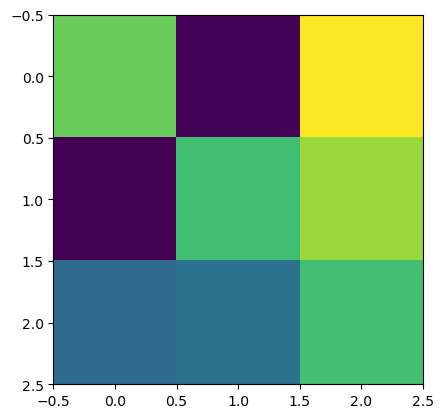

In [22]:
fig, ax = plt.subplots()
ax.imshow(A);

In [23]:
magnitudes = []
points = []

random_mat_maker = special_ortho_group(dim=A.shape[0], seed=rng).rvs
for _ in range(10_000):
    # random_mat = rng.random(size=(A.shape[0],A.shape[0]))
    # q_qr,_ = np.linalg.qr(random_mat)
    # q_svd,_,_ = np.linalg.svd(random_mat)
    # q = q_qr
    # q = q[rng.permutation(q.shape[0])]
    
    q = random_mat_maker()
    m = ((A - q)**2).sum()
    
    
    
    assert np.allclose(q.T@q, np.eye(A.shape[0])) and np.allclose(q@q.T, np.eye(A.shape[0]))
    points.append(q[:,0])
    magnitudes.append(m)

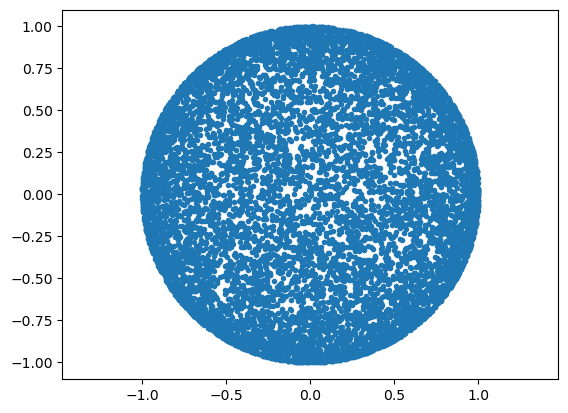

In [24]:
points = np.array(points)
plt.plot(points[:,0], points[:,1], '.')
plt.axis("equal");

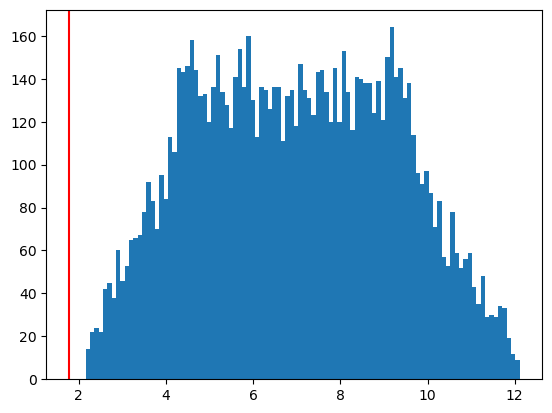

In [25]:
u, s, vh = np.linalg.svd(A)
q = u @ vh
m = ((A - q)**2).sum()
assert np.allclose(q.T@q, np.eye(A.shape[0])) and np.allclose(q@q.T, np.eye(A.shape[0]))

plt.axvline(m, color='red')
plt.hist(magnitudes, bins=100);